In [1]:
import os
import shutil
from PIL import Image
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.18.0


In [ ]:
# nutrition_data = pd.read_csv('nutrition_dpe.csv')
# nutrition_data.head()

,id,calories,proteins,fat,carbohydrate,name
0,1,280,9.2,28.4,0.0,Abon
1,2,0,0.0,0.2,0.0,Agar-agar
2,3,85,0.9,6.5,7.7,Alpukat segar
3,4,58,0.3,0.4,14.9,Apel
4,5,298,34.2,16.8,0.1,Ayam goreng kentucky dada


In [2]:
# Path ke folder dataset
image_folder_path = './food_dataset'

# Fungsi untuk menghitung jumlah gambar
def count_images_for_category(category_folder):
    """Count images in a given category folder."""
    images = [f for f in os.listdir(category_folder) if f.endswith(('.jpeg', '.jpg', '.png'))]
    print(f"There are {len(images)} images in the category '{os.path.basename(category_folder)}'.")

# Ambil semua sub-folder sebagai kategori makanan
categories = [os.path.join(image_folder_path, d) for d in os.listdir(image_folder_path) if os.path.isdir(os.path.join(image_folder_path, d))]

# Hitung jumlah gambar untuk setiap kategori
for category_folder in categories:
    count_images_for_category(category_folder)

There are 40 images in the category 'anggur'.
There are 35 images in the category 'apel'.
There are 50 images in the category 'ayam'.
There are 125 images in the category 'bakso'.
There are 29 images in the category 'bakwan'.
There are 25 images in the category 'bubur'.
There are 19 images in the category 'burger'.
There are 30 images in the category 'capcay'.
There are 40 images in the category 'cumi'.
There are 30 images in the category 'durian'.
There are 30 images in the category 'es krim'.
There are 25 images in the category 'gudeg'.
There are 100 images in the category 'ikan goreng'.
There are 30 images in the category 'jeruk'.
There are 25 images in the category 'kacang'.
There are 30 images in the category 'kentang'.
There are 23 images in the category 'kerupuk'.
There are 40 images in the category 'kopi'.
There are 100 images in the category 'lele goreng'.
There are 100 images in the category 'pempek'.
There are 100 images in the category 'sate'.
There are 100 images in the ca

In [ ]:
# print(nutrition_data.info())

# if nutrition_data.isnull().sum().any():
#     print("Data memiliki nilai kosong. Mengisi nilai kosong dengan 0...")
#     nutrition_data.fillna(0, inplace=True)

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# columns_to_normalize = ['calories', 'proteins', 'fat', 'carbohydrate']
# nutrition_data[columns_to_normalize] = scaler.fit_transform(nutrition_data[columns_to_normalize])


# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# nutrition_data['label'] = label_encoder.fit_transform(nutrition_data['name'])

# X = nutrition_data[columns_to_normalize].values  # Fitur: nutrisi
# y = nutrition_data['label'].values               # Label: nama makanan dalam format numerik

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("Data setelah preprocessing:")
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

# import joblib
# joblib.dump(label_encoder, 'label_encoder.pkl')
# print("Label encoder disimpan sebagai 'label_encoder.pkl'")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            5 non-null      int64  
 1   calories      5 non-null      int64  
 2   proteins      5 non-null      float64
 3   fat           5 non-null      float64
 4   carbohydrate  5 non-null      float64
 5   name          5 non-null      object 
dtypes: float64(3), int64(2), object(1)
memory usage: 368.0+ bytes
None
Data setelah preprocessing:
X_train shape: (4, 4)
X_test shape: (1, 4)
y_train shape: (4,)
y_test shape: (1,)
Label encoder disimpan sebagai 'label_encoder.pkl'


In [3]:
# Root directory for split data
root_dir = './food_dataset'

# Buat folder train dan validation jika belum ada
train_dir = os.path.join(root_dir, 'training')
validation_dir = os.path.join(root_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [4]:
# Function to create subdirectories for each food category
def create_train_val_dirs(food_name):
    train_food_dir = os.path.join(train_dir, food_name)
    validation_food_dir = os.path.join(validation_dir, food_name)

    os.makedirs(train_food_dir, exist_ok=True)
    os.makedirs(validation_food_dir, exist_ok=True)

# Create directories for all food categories
for category in categories:
    create_train_val_dirs(category)

In [5]:
# Function to split data into training and validation sets
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE=0.8):
    """
    Splits images in SOURCE_DIR into TRAINING_DIR and VALIDATION_DIR.
    """
    # List all image files in the source directory
    image_files = [f for f in os.listdir(SOURCE_DIR) if f.endswith(('.jpeg', '.jpg', '.png'))]

    # Shuffle and split data
    random.shuffle(image_files)
    split_index = int(len(image_files) * SPLIT_SIZE)
    train_files = image_files[:split_index]
    val_files = image_files[split_index:]

    # Copy files to respective directories
    for file_name in train_files:
        src = os.path.join(SOURCE_DIR, file_name)
        dst = os.path.join(TRAINING_DIR, file_name)
        shutil.copyfile(src, dst)

    for file_name in val_files:
        src = os.path.join(SOURCE_DIR, file_name)
        dst = os.path.join(VALIDATION_DIR, file_name)
        shutil.copyfile(src, dst)

In [7]:
import os
import shutil
import numpy as np

# Fungsi untuk memindahkan data ke folder training dan validation
def split_data_general(image_root, train_dir, validation_dir, split_size=0.8):
    # Ambil semua kategori dari folder root
    categories = [d for d in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, d))]

    for category in categories:
        source_dir = os.path.join(image_root, category)
        train_food_dir = os.path.join(train_dir, category)
        validation_food_dir = os.path.join(validation_dir, category)

        # Pastikan folder train dan validation untuk kategori ini ada
        os.makedirs(train_food_dir, exist_ok=True)
        os.makedirs(validation_food_dir, exist_ok=True)

        # Ambil semua file dari kategori ini
        all_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
        
        if not all_files:
            print(f"Warning: Tidak ada file di kategori '{category}'!")
            continue
        
        # Shuffle dan split file
        np.random.shuffle(all_files)
        split_index = int(len(all_files) * split_size)
        train_files = all_files[:split_index]
        val_files = all_files[split_index:]

        # Salin file ke folder training dan validation
        for file in train_files:
            shutil.copy(os.path.join(source_dir, file), os.path.join(train_food_dir, file))
        
        for file in val_files:
            shutil.copy(os.path.join(source_dir, file), os.path.join(validation_food_dir, file))

        # Print status
        print(f"Kategori '{category}':")
        print(f"  - {len(train_files)} file dipindahkan ke folder training")
        print(f"  - {len(val_files)} file dipindahkan ke folder validation")

# Path folder dataset
image_root = './food_dataset'
train_dir = './food_dataset/training'
validation_dir = './food_dataset/validation'

# Jalankan proses split
split_data_general(image_root, train_dir, validation_dir, split_size=0.8)

Kategori 'anggur':
  - 64 file dipindahkan ke folder training
  - 16 file dipindahkan ke folder validation
Kategori 'apel':
  - 56 file dipindahkan ke folder training
  - 14 file dipindahkan ke folder validation
Kategori 'ayam':
  - 80 file dipindahkan ke folder training
  - 20 file dipindahkan ke folder validation
Kategori 'bakso':
  - 120 file dipindahkan ke folder training
  - 30 file dipindahkan ke folder validation
Kategori 'bakwan':
  - 41 file dipindahkan ke folder training
  - 11 file dipindahkan ke folder validation
Kategori 'bubur':
  - 40 file dipindahkan ke folder training
  - 10 file dipindahkan ke folder validation
Kategori 'burger':
  - 35 file dipindahkan ke folder training
  - 9 file dipindahkan ke folder validation
Kategori 'capcay':
  - 48 file dipindahkan ke folder training
  - 12 file dipindahkan ke folder validation
Kategori 'cumi':
  - 64 file dipindahkan ke folder training
  - 16 file dipindahkan ke folder validation
Kategori 'durian':
  - 47 file dipindahkan ke

**Image Augmentation**

In [8]:
# Directories for training and validation data
train_dir = './food_dataset/training'
validation_dir = './food_dataset/validation'

# Define ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,           # Normalize pixel values (0-255 -> 0-1)
    rotation_range=30,         # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,     # Randomly translate images horizontally by 20% of width
    height_shift_range=0.2,    # Randomly translate images vertically by 20% of height
    shear_range=0.2,           # Shear intensity (for slanted images)
    zoom_range=0.2,            # Randomly zoom in/out by 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill empty pixels after augmentation
)

# Define ImageDataGenerator for validation without augmentation
val_datagen = ImageDataGenerator(
    rescale=1.0/255            # Normalize pixel values
)

# Flow data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),    # Resize images to 150x150 pixels
    batch_size=32,             # Number of images per batch
    class_mode='categorical'   # Multiclass classification
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),    # Resize images to 150x150 pixels
    batch_size=32,             # Number of images per batch
    class_mode='categorical'   # Multiclass classification
)

Found 1143 images belonging to 27 classes.
Found 286 images belonging to 27 classes.


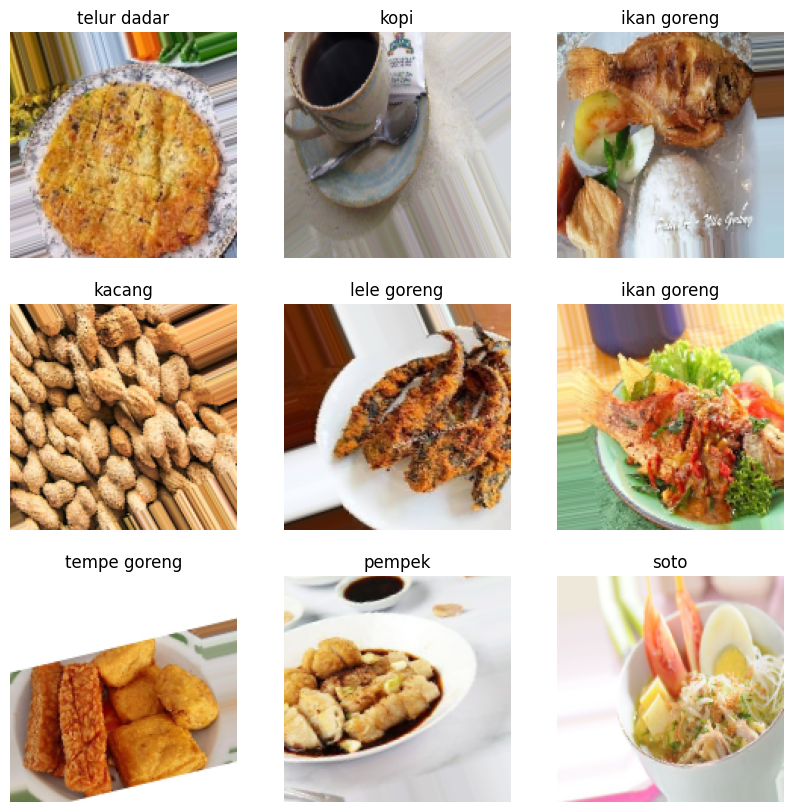

In [9]:
images, labels = next(train_generator)

# Class names dari indeks di train_generator
class_names = list(train_generator.class_indices.keys())

# Plot 9 gambar pertama
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])  # Konversi dari one-hot ke nama kelas
    plt.axis("off")
plt.show()

In [13]:
def safe_load_image(img_path):
    try:
        img = image.load_img(img_path)
        return image.img_to_array(img) / 255.0
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

def create_generator(directory, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    files = os.listdir(directory)
    valid_files = []
    for file in files:
        img_path = os.path.join(directory, file)
        img_array = safe_load_image(img_path)
        if img_array is not None:
            valid_files.append(img_path)

    # Now use valid files to create generator
    # You can modify this part to create your own custom data generator
    return valid_files

# Example of how to use
train_files = create_generator('./food_dataset/training')
print(f"Total valid training files: {len(train_files)}")

Error loading image ./food_dataset/training\anggur: name 'image' is not defined
Error loading image ./food_dataset/training\apel: name 'image' is not defined
Error loading image ./food_dataset/training\ayam: name 'image' is not defined
Error loading image ./food_dataset/training\bakso: name 'image' is not defined
Error loading image ./food_dataset/training\bakwan: name 'image' is not defined
Error loading image ./food_dataset/training\bubur: name 'image' is not defined
Error loading image ./food_dataset/training\burger: name 'image' is not defined
Error loading image ./food_dataset/training\capcay: name 'image' is not defined
Error loading image ./food_dataset/training\cumi: name 'image' is not defined
Error loading image ./food_dataset/training\durian: name 'image' is not defined
Error loading image ./food_dataset/training\es krim: name 'image' is not defined
Error loading image ./food_dataset/training\gudeg: name 'image' is not defined
Error loading image ./food_dataset/training\ikan

In [10]:
# Definisi model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Output sesuai jumlah kelas
])

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,831,835 (18.43 MB)

 Trainable params: 4,831,835 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Menyimpan model
model.save('food_classification_model.h5')

Epoch 1/10
15/36 ━━━━━━━━━━━━━━━━━━━━ 12s 590ms/step - accuracy: 0.1016 - loss: 3.1308

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: image file is truncated (2 bytes not processed)
Traceback (most recent call last):

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py", line 2079, in resize
    self.load()

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\ImageFile.py", line 254, in load
    raise OSError(

OSError: image file is truncated (2 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_2086]

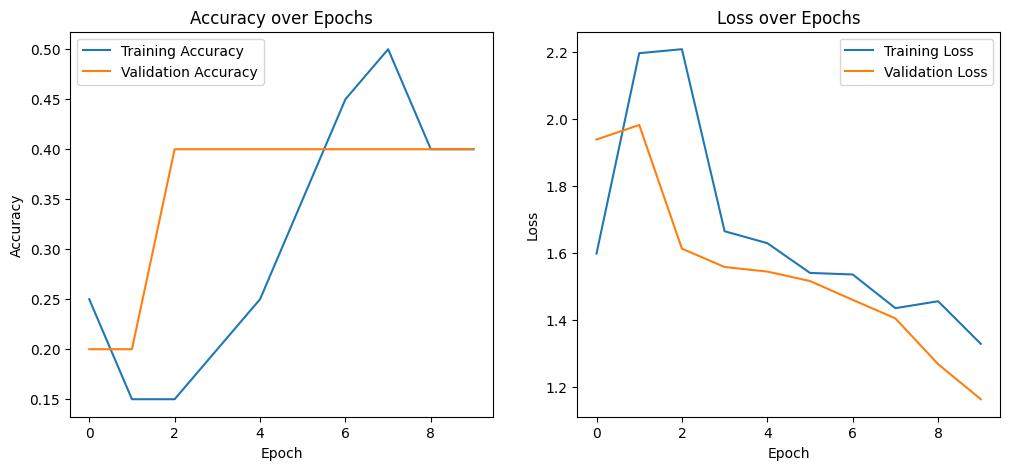

In [16]:
# Plot akurasi dan loss selama training
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()